NEW MODEL

In [1]:
import pymc as pm
import numpy as np
import jax
import multiprocessing
multiprocessing.set_start_method('spawn', force=True)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
from scipy.stats import norm, gaussian_kde

def kl_divergence(p, q, bandwidth='scott'):
    """
    Calcule la divergence KL entre deux distributions empiriques représentées par des tableaux,
    en utilisant l'estimation de densité par noyau.
    
    :param p: Premier tableau de données
    :param q: Second tableau de données
    :param bandwidth: Méthode pour estimer la largeur de bande ('scott', 'silverman' ou un nombre)
    :return: Valeur de la divergence KL
    """
    # Assurez-vous que les tableaux ont la même taille
    min_len = min(len(p), len(q))
    p = p[:min_len]
    q = q[:min_len]
    
    # Estimation de densité par noyau
    kde_p = gaussian_kde(p, bw_method=bandwidth)
    kde_q = gaussian_kde(q, bw_method=bandwidth)
    
    # Créez un espace d'échantillonnage
    x = np.linspace(min(np.min(p), np.min(q)), max(np.max(p), np.max(q)), 10000)
    
    # Estimez les densités
    p_density = kde_p(x)
    q_density = kde_q(x)
    
    # Ajoutez un petit epsilon pour éviter la division par zéro
    epsilon = 1e-10
    p_density += epsilon
    q_density += epsilon
    
    # Normalisez les densités
    p_density /= np.sum(p_density)
    q_density /= np.sum(q_density)
    
    # Calculez la divergence KL
    return np.sum(p_density * np.log(p_density / q_density))



In [3]:
import json

def load_data_from_json(file_path):
    """
    Load data from a JSON file and return it as a dictionary.
    
    :param file_path: Path to the JSON file
    :return: Dictionary containing the loaded data
    """
    try:
        with open(file_path, 'r') as file:
            data = json.load(file)
        print(f"Data successfully loaded from {file_path}")
        return data
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except json.JSONDecodeError:
        print(f"Error: Invalid JSON format in {file_path}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {str(e)}")
        return None



In [15]:
data = load_data_from_json('data/sampled_data.json')

Data successfully loaded from data/sampled_data.json


In [16]:

graph = [('a', '_b'), ('a', 'c'), ('_b', 'c'), ('c', '_d'), ('_b', '_d'), ('_d', 'e'), ('c', 'e')]
n_schools = 50
n_students = 50

unit_vars = ['a', 'c', 'e']
subunit_vars = ['b', 'd']
sizes = [n_students] * n_schools

In [17]:

# Hypothèses : Tu as des données disponibles sous forme de matrices
# A, C, E : (100,)
# B, D : (100, 50)
"""
A = np.random.normal(0, 1, 100)
C = np.random.normal(0, 1, 100)
E = np.random.normal(0, 1, 100)

B_observed = np.random.normal(0, 1, (100, 50))
D_observed = np.random.normal(0, 1, (100, 50))
"""

a = np.array([data[f'a{i}'] for i in range(n_schools)])
c = np.array([data[f'c{i}'] for i in range(n_schools)])
e = np.array([data[f'e{i}'] for i in range(n_schools)])

# For b and d, we need to create 2D arrays
b = np.array([[data[f'_b{i}_{j}'] for j in range(n_students)] for i in range(n_schools)])
d = np.array([[data[f'_d{i}_{j}'] for j in range(n_students)] for i in range(n_schools)])




In [18]:
print(a)

[ 0.24998922  2.44761422  1.40469503  0.42815749  0.16187132 -0.31809013
 -0.29305883  0.19085966  0.7557251   1.11311034  0.5939306  -0.15901988
  1.23879436 -1.78551545  0.09009554 -1.02317358  0.23072683  0.3052608
  0.7985585   0.24360876  0.41302486 -0.47930395  1.61722082  0.16208822
 -0.53642869 -0.77634811 -0.57471627 -0.79286741  0.03097524 -1.07676929
 -0.63698637 -1.16072059 -0.45839099  1.32186702  1.14335325 -1.18295317
 -0.94960291  0.75198027  0.00858142 -3.07492592 -1.64778852 -1.57243613
 -0.409503    0.61637177  0.40637725  1.50811031  1.18220863 -0.23635015
 -0.28258575  1.82161262]


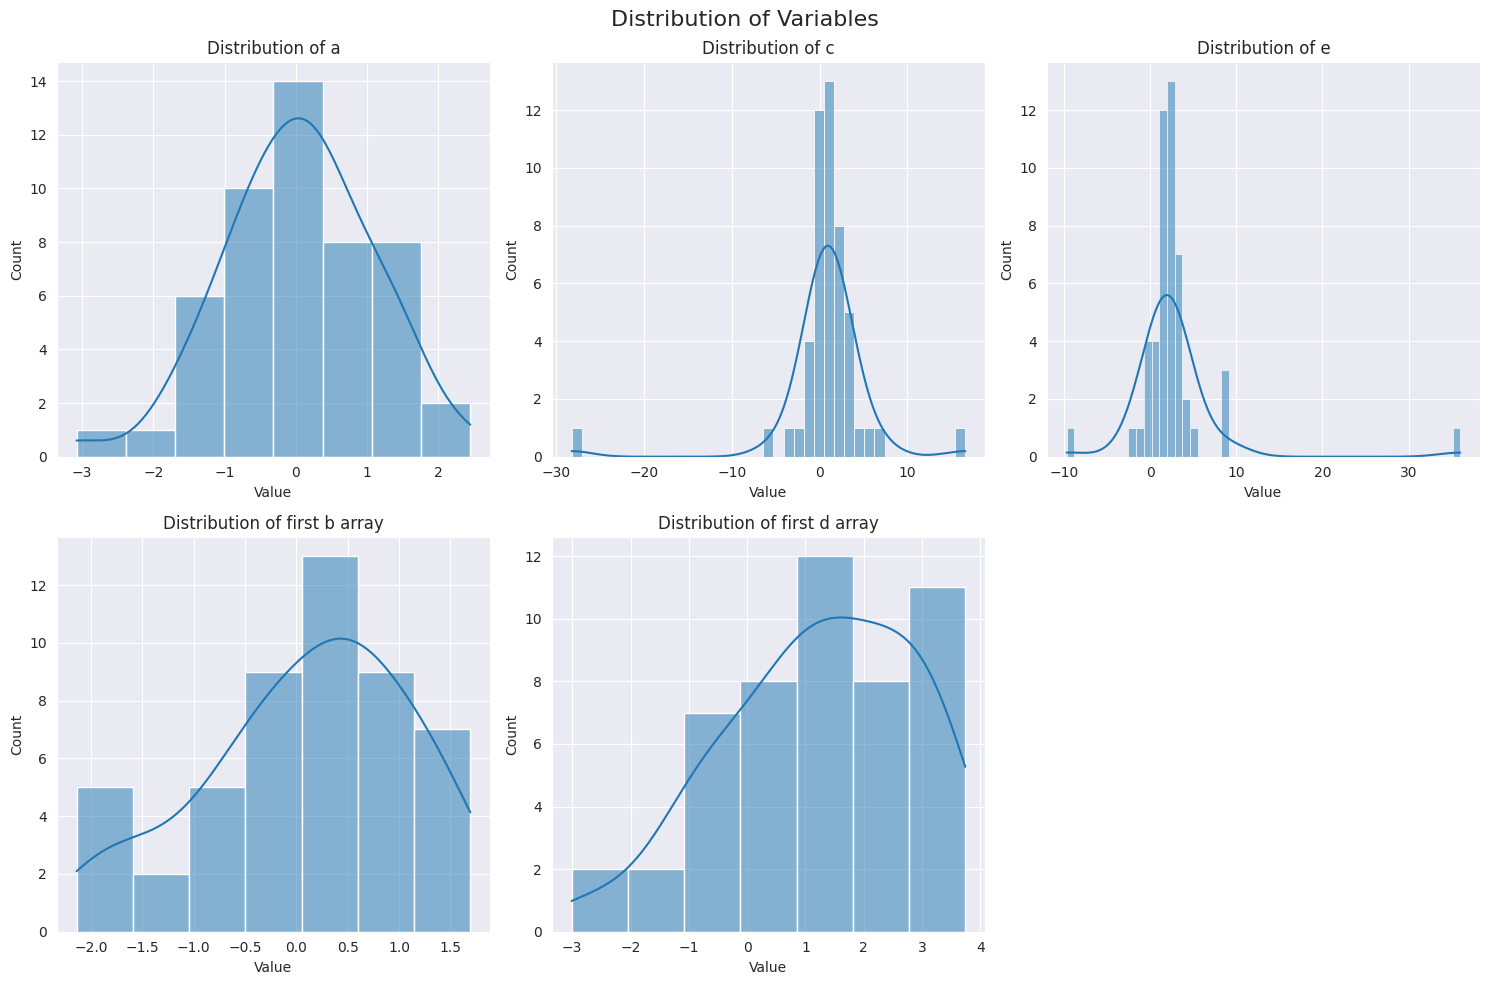

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plot
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Distribution of Variables', fontsize=16)

# Plot distribution of a
sns.histplot(a, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of a')
axes[0, 0].set_xlabel('Value')

# Plot distribution of c
sns.histplot(c, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of c')
axes[0, 1].set_xlabel('Value')

# Plot distribution of e
sns.histplot(e, kde=True, ax=axes[0, 2])
axes[0, 2].set_title('Distribution of e')
axes[0, 2].set_xlabel('Value')

# Plot distribution of first b array
sns.histplot(b[0], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of first b array')
axes[1, 0].set_xlabel('Value')

# Plot distribution of first d array
sns.histplot(d[0], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of first d array')
axes[1, 1].set_xlabel('Value')

# Remove the unused subplot
fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()


New model

In [19]:
print("Shape of a:", a.shape)
print("Shape of b:", b.shape)
print("Shape of c:", c.shape)
print("Shape of d:", d.shape)
print("Shape of e:", e.shape)


Shape of a: (50,)
Shape of b: (50, 50)
Shape of c: (50,)
Shape of d: (50, 50)
Shape of e: (50,)


In [20]:
with pm.Model() as model:
    # Niveau des écoles
    mu_A = pm.Normal('mu_A', mu=0, sigma=1)
    sigma_A = pm.HalfNormal('sigma_A', sigma=1)
    A_j = pm.Normal('A_j', mu=mu_A, sigma=sigma_A, observed=a)

    mu_C = pm.Normal('mu_C', mu=0, sigma=1)
    sigma_C = pm.HalfNormal('sigma_C', sigma=1)
    C_j = pm.Normal('C_j', mu=mu_C, sigma=sigma_C, observed=c)

    mu_E = pm.Normal('mu_E', mu=0, sigma=1)
    sigma_E = pm.HalfNormal('sigma_E', sigma=1)
    E_j = pm.Normal('E_j', mu=mu_E, sigma=sigma_E, observed=e)

    # Niveau des élèves
    mu_B = pm.Normal('mu_B', mu=0, sigma=1)
    sigma_B = pm.HalfNormal('sigma_B', sigma=1)
    B_ij = pm.Normal('B_ij', mu=mu_B, sigma=sigma_B, observed=b)

    # Modèle pour le poids des élèves (D) en fonction des autres variables
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    beta_A = pm.Normal('beta_A', mu=0, sigma=1)
    beta_C = pm.Normal('beta_C', mu=0, sigma=1)
    beta_E = pm.Normal('beta_E', mu=0, sigma=1)
    beta_B = pm.Normal('beta_B', mu=0, sigma=1)
    
    beta_D_A3 = pm.Normal('beta_D_A3', mu=1, sigma=1)
    beta_D_A2 = pm.Normal('beta_D_A2', mu=1, sigma=1)

    
    sigma_D = pm.HalfNormal('sigma_D', sigma=1)

    mu_D = alpha + beta_A * A_j[:, None] + beta_C * C_j[:, None] + beta_E * E_j[:, None] + beta_B * B_ij+ beta_D_A3 * A_j[:, None] ** 3 + beta_D_A2 * A_j[:, None] ** 2   
    D_ij = pm.Normal('D_ij', mu=mu_D, sigma=sigma_D, observed=d)

    # Inférence
    trace = pm.sample(50, return_inferencedata=True)

# Résumé des résultats
print(pm.summary(trace, var_names=['mu_A', 'mu_C', 'mu_E', 'mu_B', 'alpha', 'beta_A', 'beta_C', 'beta_E', 'beta_B']))

Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_A, sigma_A, mu_C, sigma_C, mu_E, sigma_E, mu_B, sigma_B, alpha, beta_A, beta_C, beta_E, beta_B, beta_D_A3, beta_D_A2, sigma_D]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Output()

Sampling 4 chains for 1_000 tune and 50 draw iterations (4_000 + 200 draws total) took 24 seconds.
The number of samples is too small to check convergence reliably.


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu_A    0.038  0.126  -0.194    0.300      0.006    0.009     460.0     179.0   
mu_C    0.496  0.534  -0.594    1.529      0.025    0.031     460.0     126.0   
mu_E    1.805  0.529   0.908    2.795      0.025    0.017     460.0     238.0   
mu_B   -0.015  0.020  -0.050    0.019      0.001    0.001     350.0     193.0   
alpha   0.933  0.052   0.833    1.022      0.004    0.003     194.0     186.0   
beta_A -0.034  0.031  -0.102    0.019      0.002    0.001     306.0     157.0   
beta_C -0.971  0.023  -1.010   -0.925      0.002    0.001     236.0     148.0   
beta_E  0.024  0.019  -0.008    0.059      0.001    0.001     190.0     158.0   
beta_B  1.030  0.017   0.998    1.063      0.001    0.001     460.0     189.0   

        r_hat  
mu_A     1.03  
mu_C     1.05  
mu_E     1.04  
mu_B     1.00  
alpha    1.02  
beta_A   1.01  
beta_C   1.01  
beta_E   1.01  
beta_B   1.02  


In [21]:
generated_data = {}

# a
mu_A_posterior = trace.posterior['mu_A'].mean(dim=('chain', 'draw')).values
sigma_A_posterior = trace.posterior['sigma_A'].mean(dim=('chain', 'draw')).values
new_a = np.random.normal(mu_A_posterior, sigma_A_posterior, size=n_schools)
generated_data['a'] = new_a

# c
mu_C_posterior = trace.posterior['mu_C'].mean(dim=('chain', 'draw')).values
sigma_C_posterior = trace.posterior['sigma_C'].mean(dim=('chain', 'draw')).values
new_c = np.random.normal(mu_C_posterior, sigma_C_posterior, size=n_schools)
generated_data['c'] = new_c

# e
mu_E_posterior = trace.posterior['mu_E'].mean(dim=('chain', 'draw')).values
sigma_E_posterior = trace.posterior['sigma_E'].mean(dim=('chain', 'draw')).values
new_e = np.random.normal(mu_E_posterior, sigma_E_posterior, size=n_schools)
generated_data['e'] = new_e


# Pour B
mu_B = trace.posterior['mu_B'].mean(dim=('chain', 'draw')).values
sigma_B = trace.posterior['sigma_B'].mean(dim=('chain', 'draw')).values
generated_data['b'] = np.random.normal(mu_B, sigma_B, size=(n_schools, n_students))

# Pour D, nous devons recalculer mu_D en utilisant les paramètres estimés
alpha = trace.posterior['alpha'].mean(dim=('chain', 'draw')).values
beta_A = trace.posterior['beta_A'].mean(dim=('chain', 'draw')).values
beta_C = trace.posterior['beta_C'].mean(dim=('chain', 'draw')).values
beta_E = trace.posterior['beta_E'].mean(dim=('chain', 'draw')).values
beta_B = trace.posterior['beta_B'].mean(dim=('chain', 'draw')).values
sigma_D = trace.posterior['sigma_D'].mean(dim=('chain', 'draw')).values

# Calcul de mu_D
mu_D = (alpha + 
        beta_A * new_a[:, np.newaxis] + 
        beta_C * new_c[:, np.newaxis] + 
        beta_E * new_e[:, np.newaxis] + 
        beta_B * generated_data['b'])

generated_data['d'] = np.random.normal(mu_D, sigma_D)

# Affichage des formes des données générées
for var in ['a', 'b', 'c', 'd', 'e']:
    print(f"Shape of generated {var}: {generated_data[var].shape}")

print("Generated data:", generated_data)

Shape of generated a: (50,)
Shape of generated b: (50, 50)
Shape of generated c: (50,)
Shape of generated d: (50, 50)
Shape of generated e: (50,)
Generated data: {'a': array([-1.94730633, -0.61325228,  0.30620404,  0.78084553, -1.42266699,
        0.05999895, -2.14399326, -0.93361489,  2.33718636, -0.54376396,
       -0.63123287,  0.48041343, -2.29844237,  0.90856942,  0.93895825,
        0.41632245,  0.010595  ,  0.72652437,  1.85868461,  0.40089056,
        1.83885238,  0.31792622,  0.69947892,  0.08736282, -0.08796907,
       -0.15634646,  1.41481767, -0.50703396,  1.38448281,  0.53983309,
        0.31246897,  0.94585066,  0.82017182, -0.34169119,  0.24496598,
        0.30327438,  0.98109471,  1.23642456,  0.45788879,  1.08127687,
        0.13830106,  0.5938949 ,  1.55131904,  0.27292105,  0.78538344,
        0.35279652, -0.26966523,  0.13656718,  2.10358904,  1.80859848]), 'c': array([ -0.17578761,   3.90008856,  -5.17450339,   6.19583737,
        -2.43764442,  -0.71214639,   2.457

In [22]:
# Calcul des divergences KL
kl_divs = {}

for var in ['a', 'b', 'c', 'd', 'e']:
    original = eval(var)  # Les données originales
    generated = generated_data[var]  # Les données générées
    
    # Pour b et d, nous devons aplatir les arrays 2D
    if var in ['b', 'd']:
        original = original.flatten()
        generated = generated.flatten()
    
    kl_divs[var] = kl_divergence(original, generated)

# Affichage des résultats
for var, kl_div in kl_divs.items():
    print(f"KL divergence pour {var}: {kl_div}")

KL divergence pour a: 0.08013691104720264
KL divergence pour b: 0.0027760205398979394
KL divergence pour c: 0.308124505896397
KL divergence pour d: 0.6607241619333393
KL divergence pour e: 0.23175603105829495


/tmp/ipykernel_24339/4079375146.py:22: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original, ax=ax, color='blue', label='Original', shade=True)
/tmp/ipykernel_24339/4079375146.py:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(generated, ax=ax, color='red', label='Generated', shade=True)
/tmp/ipykernel_24339/4079375146.py:22: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original, ax=ax, color='blue', label='Original', shade=True)
/tmp/ipykernel_24339/4079375146.py:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your c

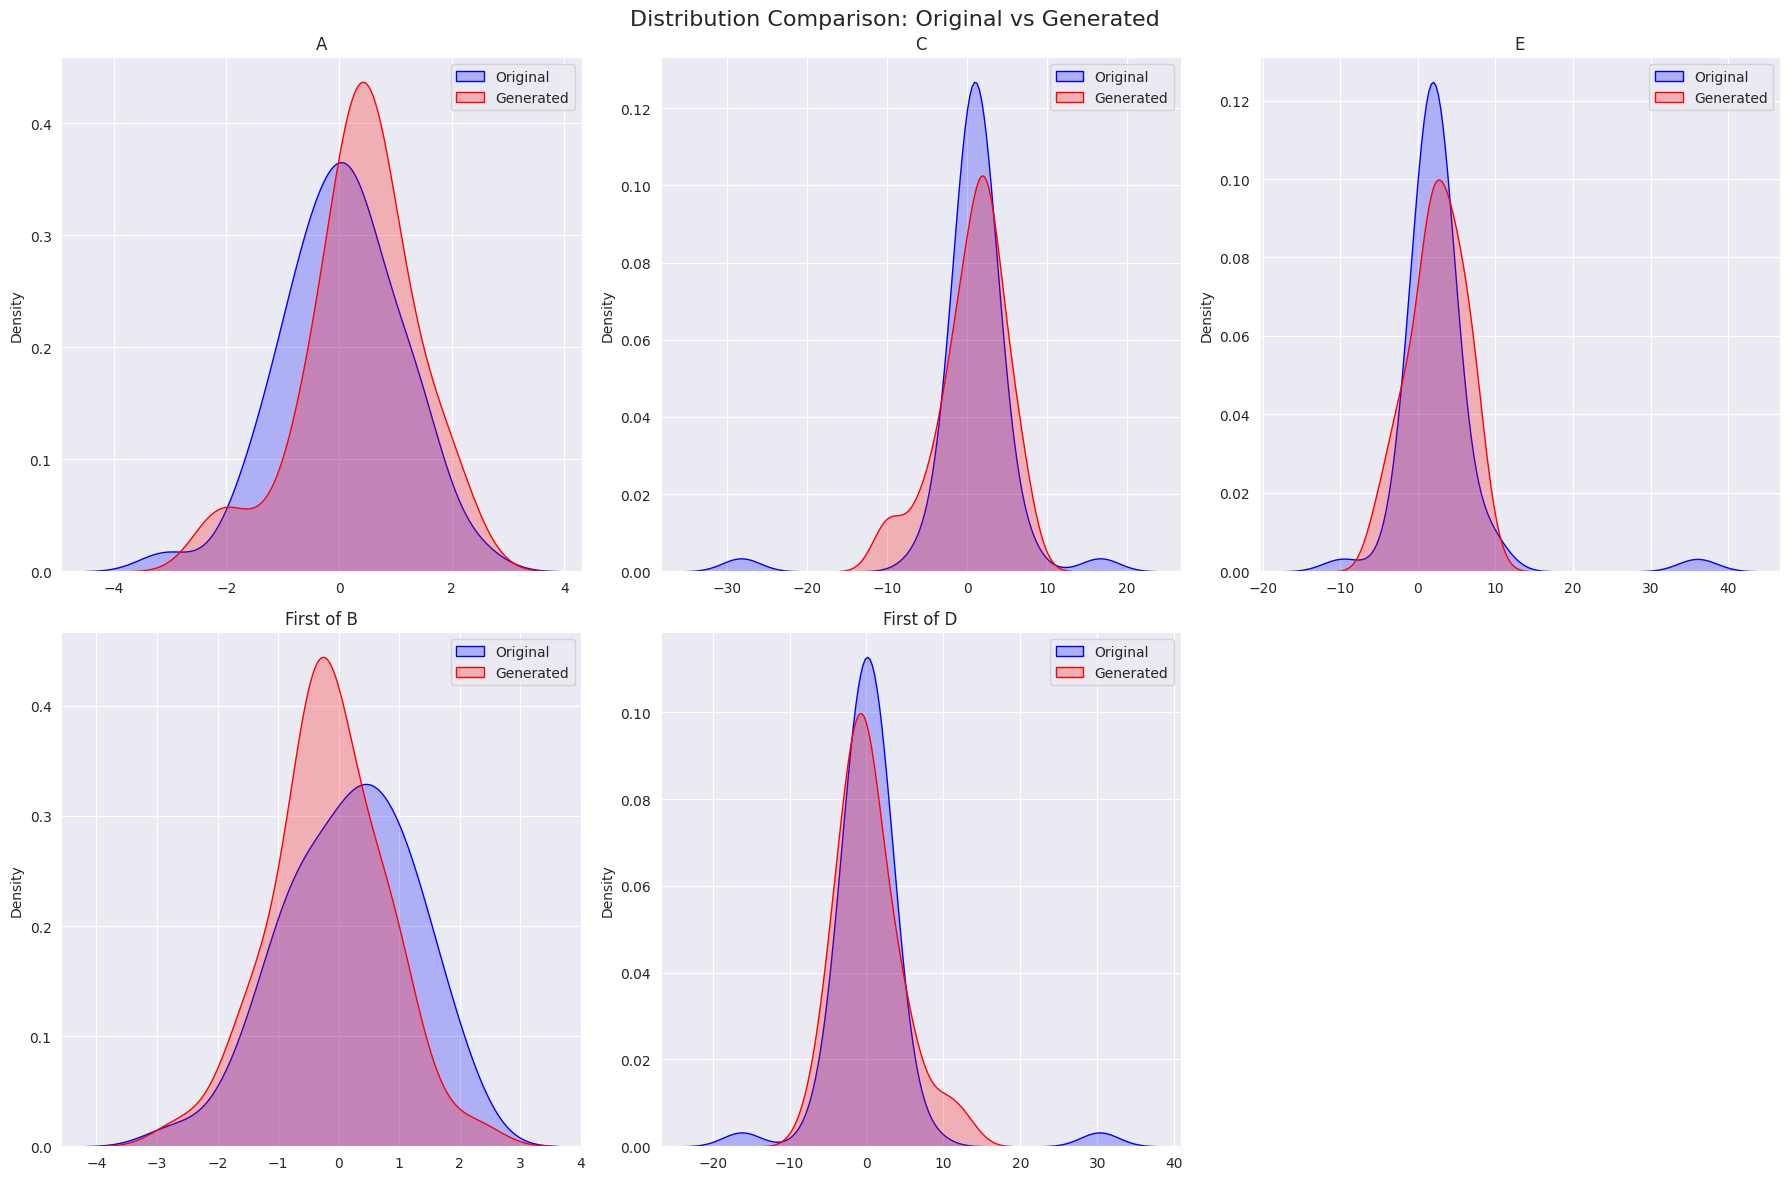

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots for A, C, E, first of B, and first of D
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Distribution Comparison: Original vs Generated', fontsize=16)

variables = ['a', 'c', 'e', 'b', 'd']
titles = ['A', 'C', 'E', 'First of B', 'First of D']

for i, (var, title) in enumerate(zip(variables, titles)):
    ax = axs[i // 3, i % 3]
    
    # Original data
    if var in ['b', 'd']:
        original = eval(var)[:, 3]  # Take first column for B and D
        generated = generated_data[var][:, 3]
    else:
        original = eval(var)
        generated = generated_data[var]
    
    sns.kdeplot(original, ax=ax, color='blue', label='Original', shade=True)
    sns.kdeplot(generated, ax=ax, color='red', label='Generated', shade=True)
    
    ax.set_title(title)
    ax.legend()

# Remove the empty subplot
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()


---------------------------------------------------------------------------------------------------------------------------------------------------

----------------------------------- Avec intervention -------------------------------------------------------------------------------------------

------------------------------------------------------------

In [20]:
with pm.Model() as model:
    # Niveau des écoles (A)
    mu_A = pm.Normal('mu_A', mu=0, sigma=1)
    sigma_A = pm.HalfNormal('sigma_A', sigma=1)
    A_j = pm.Normal('A_j', mu=mu_A, sigma=sigma_A, observed=a)

    # Niveau des élèves (B)
    B_ij = pm.Normal('B_ij', mu=A_j[:, None], sigma=1, observed=b)

    # Variable C
    mu_C = A_j**3 + (pm.math.mean(B_ij, axis=1) + 1)**2
    sigma_C = pm.HalfNormal('sigma_C', sigma=1)
    C_j = pm.Normal('C_j', mu=mu_C, sigma=sigma_C, observed=c)

    # Variable D
    mu_D = B_ij + 1 - C_j[:, None]
    sigma_D = pm.HalfNormal('sigma_D', sigma=1)
    D_ij = pm.Normal('D_ij', mu=mu_D, sigma=sigma_D, observed=d)

    # Variable E
    mu_E = pm.math.mean(D_ij, axis=1) + 1 + pm.math.sqrt(pm.math.abs(C_j))
    sigma_E = pm.HalfNormal('sigma_E', sigma=1)
    E_j = pm.Normal('E_j', mu=mu_E, sigma=sigma_E, observed=e)

    # Inférence
    trace = pm.sample(50, return_inferencedata=True)

# Résumé des résultats
print(pm.summary(trace, var_names=['mu_A', 'sigma_A', 'sigma_C', 'sigma_D', 'sigma_E']))

Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_A, sigma_A, sigma_C, sigma_D, sigma_E]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Output()

Sampling 4 chains for 1_000 tune and 50 draw iterations (4_000 + 200 draws total) took 10 seconds.
The number of samples is too small to check convergence reliably.


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_A     0.041  0.143  -0.253    0.301      0.007    0.009     460.0   
sigma_A  1.059  0.120   0.871    1.295      0.006    0.005     362.0   
sigma_C  1.051  0.116   0.871    1.254      0.008    0.006     225.0   
sigma_D  0.984  0.014   0.962    1.012      0.001    0.001     331.0   
sigma_E  1.086  0.112   0.882    1.262      0.006    0.005     285.0   

         ess_tail  r_hat  
mu_A        159.0   1.01  
sigma_A     158.0   1.07  
sigma_C     161.0   1.02  
sigma_D     148.0   1.02  
sigma_E     185.0   1.00  


In [21]:
# Résumé des résultats
print(pm.summary(trace, var_names=['mu_A', 'sigma_A', 'sigma_C', 'sigma_D', 'sigma_E']))

          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_A     0.041  0.143  -0.253    0.301      0.007    0.009     460.0   
sigma_A  1.059  0.120   0.871    1.295      0.006    0.005     362.0   
sigma_C  1.051  0.116   0.871    1.254      0.008    0.006     225.0   
sigma_D  0.984  0.014   0.962    1.012      0.001    0.001     331.0   
sigma_E  1.086  0.112   0.882    1.262      0.006    0.005     285.0   

         ess_tail  r_hat  
mu_A        159.0   1.01  
sigma_A     158.0   1.07  
sigma_C     161.0   1.02  
sigma_D     148.0   1.02  
sigma_E     185.0   1.00  


In [22]:
generated_data_cond = {}

# a
mu_A_posterior = trace.posterior['mu_A'].mean(dim=('chain', 'draw')).values
sigma_A_posterior = trace.posterior['sigma_A'].mean(dim=('chain', 'draw')).values
new_a = np.random.normal(mu_A_posterior, sigma_A_posterior, size=n_schools)
generated_data_cond['a'] = new_a


# b
generated_data_cond['b'] = np.random.normal(new_a[:, None], 1, size=(n_schools, n_students))

# c
mu_C = new_a**3 + (np.mean(generated_data_cond['b'], axis=1) + 1)**2
sigma_C_posterior = trace.posterior['sigma_C'].mean(dim=('chain', 'draw')).values
new_c = np.random.normal(mu_C, sigma_C_posterior, size=n_schools)
generated_data_cond['c'] = new_c


# d
mu_D = generated_data_cond['b'] + 1 - new_c[:, None]
sigma_D_posterior = trace.posterior['sigma_D'].mean(dim=('chain', 'draw')).values
generated_data_cond['d'] = np.random.normal(mu_D, sigma_D_posterior, size=(n_schools, n_students))

# e
mu_E = np.mean(generated_data_cond['d'], axis=1) + 1 + np.sqrt(np.abs(new_c))
sigma_E_posterior = trace.posterior['sigma_E'].mean(dim=('chain', 'draw')).values
new_e = np.random.normal(mu_E, sigma_E_posterior, size=n_schools)
generated_data_cond['e'] = new_e

# Affichage des formes des données générées
for var in ['a', 'b', 'c', 'd', 'e']:
    print(f"Shape of generated {var}: {generated_data_cond[var].shape}")

print("Generated data:", generated_data_cond)

Shape of generated a: (50,)
Shape of generated b: (50, 50)
Shape of generated c: (50,)
Shape of generated d: (50, 50)
Shape of generated e: (50,)
Generated data: {'a': array([-0.28649225,  0.37253085,  0.02626245, -0.48155362,  0.11397406,
       -0.62063182,  0.68837785,  0.64015044,  0.30262212, -0.23739497,
        1.76640507,  0.47404201, -0.34887594, -0.91548534, -0.27020662,
       -0.32570005, -0.38228491, -0.9496911 ,  0.72367408, -1.527251  ,
        1.09025276, -1.73805975, -1.43630407,  0.64605009,  0.61803946,
        1.01662171,  0.35752833, -0.54963412, -0.48099633,  0.01686979,
        1.94653153,  0.95153939, -1.67947294,  0.70337671,  2.15658639,
       -0.33633349,  1.25338274, -1.11754823,  1.18259531, -0.72240049,
       -0.80817656,  0.50494049,  0.56086679, -0.61244943, -0.98185499,
        0.63374773,  2.3028868 ,  0.30466022, -0.16061701, -0.45349354]), 'b': array([[-0.23403765, -0.29629012,  0.57238976, ...,  0.45469401,
         0.82372129, -0.46504166],
     

In [23]:
# Calcul des divergences KL
kl_divs = {}

for var in ['a', 'b', 'c', 'd', 'e']:
    original = eval(var)  # Les données originales
    generated = generated_data_cond[var]  # Les données générées
    
    # Pour b et d, nous devons aplatir les arrays 2D
    if var in ['b', 'd']:
        original = original.flatten()
        generated = generated.flatten()
    
    kl_divs[var] = kl_divergence(original, generated)

# Affichage des résultats
for var, kl_div in kl_divs.items():
    print(f"KL divergence pour {var}: {kl_div}")

KL divergence pour a: 0.019535639858380444
KL divergence pour b: 0.09421835236133298
KL divergence pour c: 0.21314185289664256
KL divergence pour d: 0.39366807064456333
KL divergence pour e: 0.26798530415532007


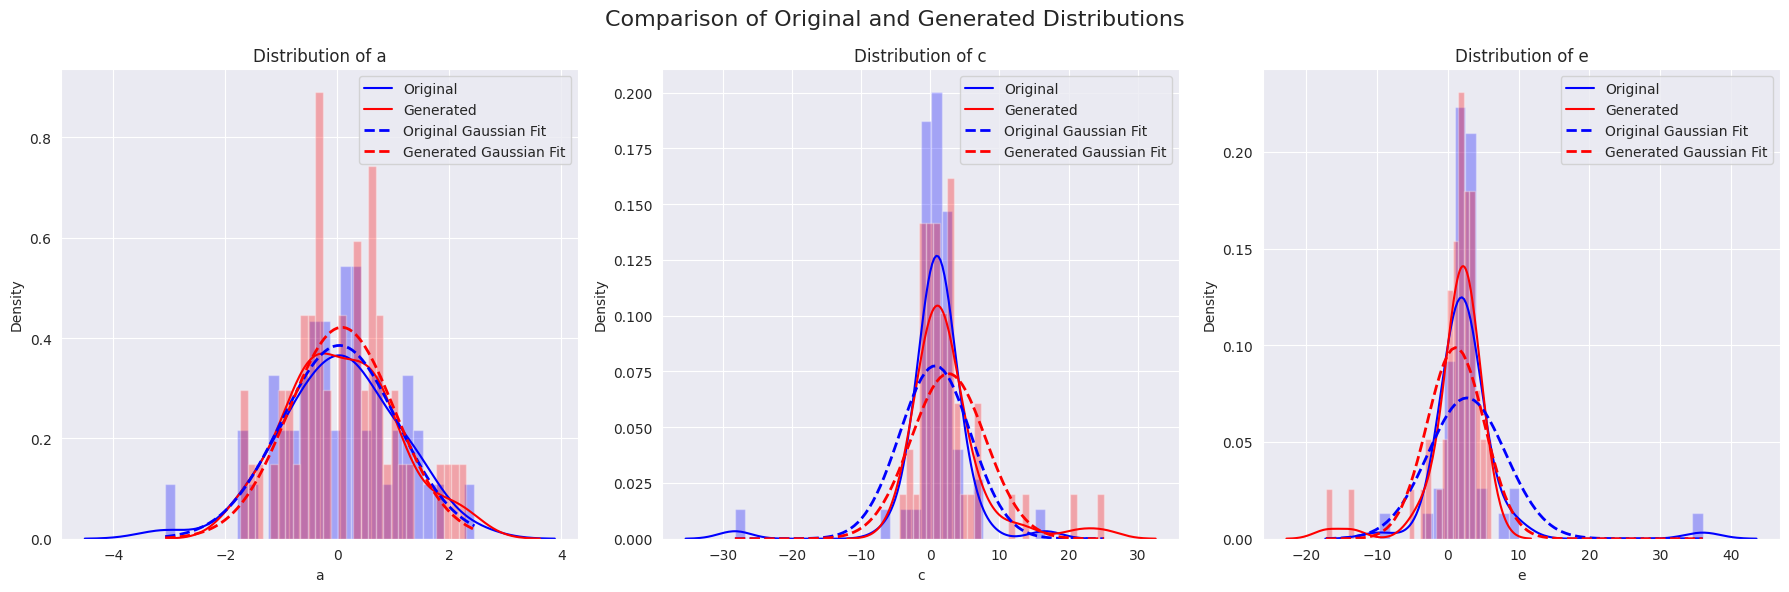

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Variables to plot
variables = ['a', 'c', 'e']

# Set up the plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Comparison of Original and Generated Distributions', fontsize=16)

for i, var in enumerate(variables):
    ax = axes[i]
    
    # Original data
    original = eval(var)
    
    # Generated data
    generated = generated_data_cond[var]
    
    # KDE plot
    sns.kdeplot(original, ax=ax, label='Original', color='blue')
    sns.kdeplot(generated, ax=ax, label='Generated', color='red')
    
    # Histogram
    ax.hist(original, bins=30, alpha=0.3, color='blue', density=True)
    ax.hist(generated, bins=30, alpha=0.3, color='red', density=True)
    
    # Fit normal distribution
    mu_orig, std_orig = stats.norm.fit(original)
    mu_gen, std_gen = stats.norm.fit(generated)
    
    x = np.linspace(min(original.min(), generated.min()), 
                    max(original.max(), generated.max()), 100)
    
    ax.plot(x, stats.norm.pdf(x, mu_orig, std_orig), 
            'b--', linewidth=2, label='Original Gaussian Fit')
    ax.plot(x, stats.norm.pdf(x, mu_gen, std_gen), 
            'r--', linewidth=2, label='Generated Gaussian Fit')
    
    ax.set_title(f'Distribution of {var}')
    ax.set_xlabel(var)
    ax.set_ylabel('Density')
    ax.legend()

plt.tight_layout()
plt.show()


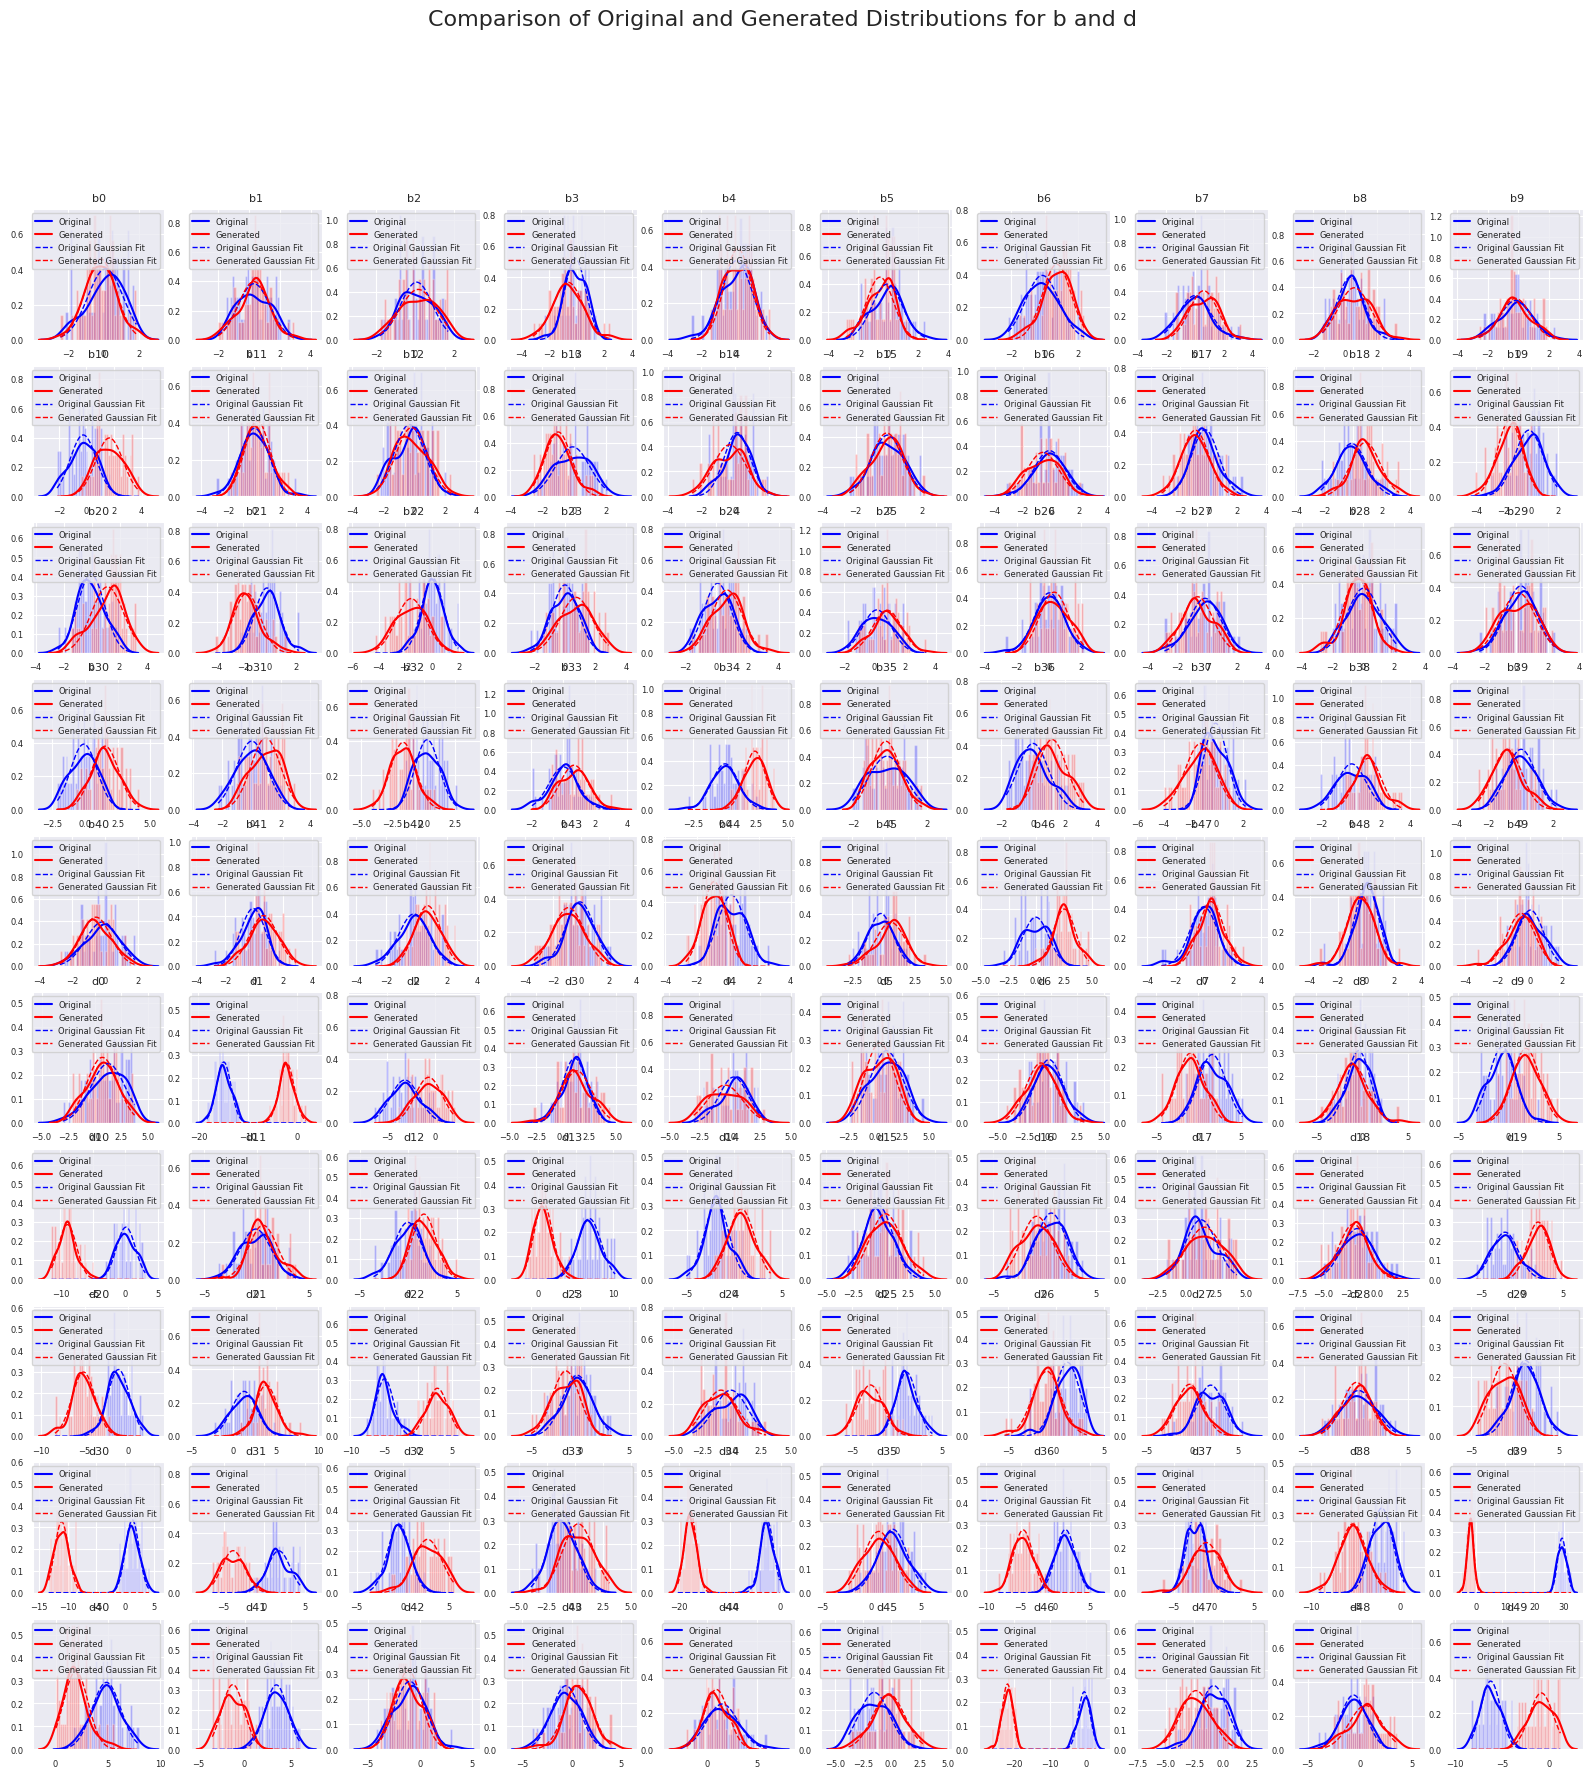

In [25]:
# Variables to plot
variables_bd = ['b', 'd']

# Set up the plot
fig, axes = plt.subplots(10, 10, figsize=(20, 20))
fig.suptitle('Comparison of Original and Generated Distributions for b and d', fontsize=16)

for i, var in enumerate(variables_bd):
    for j in range(50):
        ax = axes[5*i+j//10, j%10]
        
        # Original data
        original = eval(f'{var}')[j]
        
        # Generated data
        generated = generated_data_cond[f'{var}'][j]
        
        # KDE plot
        sns.kdeplot(original, ax=ax, label='Original', color='blue')
        sns.kdeplot(generated, ax=ax, label='Generated', color='red')
        
        # Histogram
        ax.hist(original, bins=30, alpha=0.3, color='blue', density=True)
        ax.hist(generated, bins=30, alpha=0.3, color='red', density=True)
        
        # Fit normal distribution
        mu_orig, std_orig = stats.norm.fit(original)
        mu_gen, std_gen = stats.norm.fit(generated)
        
        x = np.linspace(min(original.min(), generated.min()), 
                        max(original.max(), generated.max()), 100)
        
        ax.plot(x, stats.norm.pdf(x, mu_orig, std_orig), 
                'b--', linewidth=1, label='Original Gaussian Fit')
        ax.plot(x, stats.norm.pdf(x, mu_gen, std_gen), 
                'r--', linewidth=1, label='Generated Gaussian Fit')
        
        ax.set_title(f'{var}{j}', fontsize=8)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.tick_params(axis='both', which='both', labelsize=6)
        ax.legend(fontsize=6)

plt.show()


In [34]:
def experiment(n):
    all_kl_divs = []
    for k in range(n):
        data = load_data_from_json(f'data/sampled_intervention_{k}.json')
            
        a = np.array([data[f'a{i}'] for i in range(n_schools)])
        c = np.array([data[f'c{i}'] for i in range(n_schools)])
        e = np.array([data[f'e{i}'] for i in range(n_schools)])
        
        # For b and d, we need to create 2D arrays
        b = np.array([[data[f'_b{i}_{j}'] for j in range(n_students)] for i in range(n_schools)])
        d = np.array([[data[f'_d{i}_{j}'] for j in range(n_students)] for i in range(n_schools)])
        
        with pm.Model() as model:
    # Niveau des écoles (A)
            mu_A = pm.Normal('mu_A', mu=0, sigma=1)
            sigma_A = pm.HalfNormal('sigma_A', sigma=1)
            A_j = pm.Normal('A_j', mu=mu_A, sigma=sigma_A, observed=a)
        
            # Niveau des élèves (B)
            B_ij = pm.Normal('B_ij', mu=A_j[:, None], sigma=1, observed=b)
        
            # Variable C
            mu_C = A_j**3 + (pm.math.mean(B_ij, axis=1) + 1)**2
            sigma_C = pm.HalfNormal('sigma_C', sigma=1)
            C_j = pm.Normal('C_j', mu=mu_C, sigma=sigma_C, observed=c)
        
            # Variable D
            mu_D = B_ij + 1 - C_j[:, None]
            sigma_D = pm.HalfNormal('sigma_D', sigma=1)
            D_ij = pm.Normal('D_ij', mu=mu_D, sigma=sigma_D, observed=d)
        
            # Variable E
            mu_E = pm.math.mean(D_ij, axis=1) + 1 + pm.math.sqrt(pm.math.abs(C_j))
            sigma_E = pm.HalfNormal('sigma_E', sigma=1)
            E_j = pm.Normal('E_j', mu=mu_E, sigma=sigma_E, observed=e)
        
            # Inférence
            trace = pm.sample(50, return_inferencedata=True)
    
    # Résumé des résultats
        print(pm.summary(trace, var_names=['mu_A', 'sigma_A', 'sigma_C', 'sigma_D', 'sigma_E']))
        
        generated_data_cond = {}
        
        # a
        mu_A_posterior = trace.posterior['mu_A'].mean(dim=('chain', 'draw')).values
        sigma_A_posterior = trace.posterior['sigma_A'].mean(dim=('chain', 'draw')).values
        new_a = np.random.normal(mu_A_posterior, sigma_A_posterior, size=n_schools)
        generated_data_cond['a'] = new_a
        
        
        # b
        generated_data_cond['b'] = np.random.normal(new_a[:, None], 1, size=(n_schools, n_students))
        
        # c
        mu_C = new_a**3 + (np.mean(generated_data_cond['b'], axis=1) + 1)**2
        sigma_C_posterior = trace.posterior['sigma_C'].mean(dim=('chain', 'draw')).values
        new_c = np.random.normal(mu_C, sigma_C_posterior, size=n_schools)
        generated_data_cond['c'] = new_c
        
        
        # d
        mu_D = generated_data_cond['b'] + 1 - new_c[:, None]
        sigma_D_posterior = trace.posterior['sigma_D'].mean(dim=('chain', 'draw')).values
        generated_data_cond['d'] = np.random.normal(mu_D, sigma_D_posterior, size=(n_schools, n_students))
        
        # e
        mu_E = np.mean(generated_data_cond['d'], axis=1) + 1 + np.sqrt(np.abs(new_c))
        sigma_E_posterior = trace.posterior['sigma_E'].mean(dim=('chain', 'draw')).values
        new_e = np.random.normal(mu_E, sigma_E_posterior, size=n_schools)
        generated_data_cond['e'] = new_e
                
        
        kl_divs = {}
        
        for var in ['a', 'b', 'c', 'd', 'e']:
            original = eval(var)  # Les données originales
            generated = generated_data_cond[var]  # Les données générées
            
            # Pour b et d, nous devons aplatir les arrays 2D
            if var in ['b', 'd']:
                original = original.flatten()
                generated = generated.flatten()
            
            kl_divs[var] = kl_divergence(original, generated)
        
        all_kl_divs.append(kl_divs)
    return all_kl_divs
    
        

            
    

In [35]:
kl_divs = experiment(10)

Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


Data successfully loaded from data/sampled_intervention_0.json


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_A, sigma_A, sigma_C, sigma_D, sigma_E]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Output()

Sampling 4 chains for 1_000 tune and 50 draw iterations (4_000 + 200 draws total) took 10 seconds.
The number of samples is too small to check convergence reliably.


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_A     0.396  0.119   0.161    0.586      0.007    0.005     292.0   
sigma_A  0.863  0.097   0.681    1.057      0.005    0.004     330.0   
sigma_C  1.024  0.119   0.814    1.255      0.008    0.006     290.0   
sigma_D  1.005  0.014   0.980    1.032      0.001    0.001      98.0   
sigma_E  0.906  0.084   0.752    1.056      0.004    0.003     440.0   

         ess_tail  r_hat  
mu_A        228.0   1.00  
sigma_A     161.0   1.00  
sigma_C     135.0   1.01  
sigma_D     191.0   1.04  
sigma_E     190.0   0.99  


Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


Data successfully loaded from data/sampled_intervention_1.json


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_A, sigma_A, sigma_C, sigma_D, sigma_E]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Output()

Sampling 4 chains for 1_000 tune and 50 draw iterations (4_000 + 200 draws total) took 10 seconds.
The number of samples is too small to check convergence reliably.


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_A     0.390  0.103   0.201    0.586      0.006    0.004     346.0   
sigma_A  0.860  0.091   0.713    1.028      0.005    0.004     356.0   
sigma_C  1.015  0.108   0.826    1.223      0.007    0.005     258.0   
sigma_D  1.004  0.014   0.976    1.027      0.001    0.001     254.0   
sigma_E  0.898  0.101   0.720    1.073      0.005    0.003     460.0   

         ess_tail  r_hat  
mu_A        148.0   1.02  
sigma_A     154.0   1.00  
sigma_C     159.0   1.01  
sigma_D     190.0   1.00  
sigma_E     102.0   1.06  


Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


Data successfully loaded from data/sampled_intervention_2.json


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_A, sigma_A, sigma_C, sigma_D, sigma_E]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Output()

Sampling 4 chains for 1_000 tune and 50 draw iterations (4_000 + 200 draws total) took 10 seconds.
The number of samples is too small to check convergence reliably.


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_A     0.403  0.130   0.145    0.640      0.006    0.005     400.0   
sigma_A  0.863  0.095   0.681    1.021      0.005    0.003     460.0   
sigma_C  0.990  0.089   0.855    1.171      0.005    0.004     288.0   
sigma_D  1.005  0.013   0.980    1.030      0.001    0.000     460.0   
sigma_E  0.913  0.098   0.745    1.105      0.005    0.003     460.0   

         ess_tail  r_hat  
mu_A        233.0   0.99  
sigma_A     180.0   1.04  
sigma_C     189.0   1.02  
sigma_D     179.0   0.99  
sigma_E     239.0   1.03  


Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


Data successfully loaded from data/sampled_intervention_3.json


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_A, sigma_A, sigma_C, sigma_D, sigma_E]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Output()

Sampling 4 chains for 1_000 tune and 50 draw iterations (4_000 + 200 draws total) took 10 seconds.
The number of samples is too small to check convergence reliably.


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_A     0.394  0.116   0.180    0.600      0.007    0.005     275.0   
sigma_A  0.863  0.082   0.721    1.015      0.004    0.003     358.0   
sigma_C  1.014  0.109   0.807    1.210      0.007    0.005     332.0   
sigma_D  1.005  0.014   0.978    1.031      0.001    0.000     399.0   
sigma_E  0.902  0.103   0.720    1.066      0.006    0.004     306.0   

         ess_tail  r_hat  
mu_A        125.0   1.01  
sigma_A     141.0   1.01  
sigma_C     118.0   1.01  
sigma_D     175.0   1.02  
sigma_E     193.0   1.02  


Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


Data successfully loaded from data/sampled_intervention_4.json


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_A, sigma_A, sigma_C, sigma_D, sigma_E]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Output()

Sampling 4 chains for 1_000 tune and 50 draw iterations (4_000 + 200 draws total) took 10 seconds.
The number of samples is too small to check convergence reliably.


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_A     0.398  0.116   0.192    0.614      0.006    0.004     382.0   
sigma_A  0.863  0.096   0.681    1.037      0.004    0.003     429.0   
sigma_C  1.013  0.103   0.844    1.207      0.005    0.004     399.0   
sigma_D  1.004  0.014   0.978    1.027      0.001    0.000     460.0   
sigma_E  0.903  0.090   0.752    1.070      0.004    0.003     460.0   

         ess_tail  r_hat  
mu_A        185.0   1.01  
sigma_A     118.0   1.05  
sigma_C     223.0   1.04  
sigma_D     195.0   1.00  
sigma_E     157.0   0.99  


Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


Data successfully loaded from data/sampled_intervention_5.json


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_A, sigma_A, sigma_C, sigma_D, sigma_E]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Output()

Sampling 4 chains for 1_000 tune and 50 draw iterations (4_000 + 200 draws total) took 10 seconds.
The number of samples is too small to check convergence reliably.


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_A     0.406  0.130   0.141    0.624      0.006    0.004     460.0   
sigma_A  0.869  0.086   0.714    1.019      0.005    0.003     397.0   
sigma_C  1.009  0.103   0.841    1.198      0.006    0.005     315.0   
sigma_D  1.005  0.015   0.973    1.028      0.001    0.001     277.0   
sigma_E  0.910  0.098   0.723    1.078      0.005    0.004     370.0   

         ess_tail  r_hat  
mu_A        206.0   1.04  
sigma_A     155.0   1.00  
sigma_C     160.0   1.03  
sigma_D     159.0   1.01  
sigma_E     186.0   1.02  


Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


Data successfully loaded from data/sampled_intervention_6.json


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_A, sigma_A, sigma_C, sigma_D, sigma_E]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Output()

Sampling 4 chains for 1_000 tune and 50 draw iterations (4_000 + 200 draws total) took 10 seconds.
The number of samples is too small to check convergence reliably.


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_A     0.392  0.111   0.192    0.583      0.010    0.007     134.0   
sigma_A  0.873  0.100   0.707    1.063      0.006    0.005     395.0   
sigma_C  1.019  0.113   0.813    1.221      0.006    0.004     363.0   
sigma_D  1.003  0.014   0.980    1.034      0.001    0.000     460.0   
sigma_E  0.919  0.096   0.752    1.104      0.006    0.004     256.0   

         ess_tail  r_hat  
mu_A        145.0   1.01  
sigma_A     160.0   1.00  
sigma_C     139.0   1.05  
sigma_D     195.0   1.03  
sigma_E     157.0   1.00  


Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


Data successfully loaded from data/sampled_intervention_7.json


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_A, sigma_A, sigma_C, sigma_D, sigma_E]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Output()

Sampling 4 chains for 1_000 tune and 50 draw iterations (4_000 + 200 draws total) took 10 seconds.
The number of samples is too small to check convergence reliably.


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_A     0.399  0.122   0.217    0.675      0.008    0.005     266.0   
sigma_A  0.868  0.098   0.677    1.024      0.005    0.003     460.0   
sigma_C  1.015  0.106   0.859    1.236      0.006    0.004     393.0   
sigma_D  1.005  0.014   0.978    1.032      0.001    0.001     296.0   
sigma_E  0.892  0.084   0.730    1.024      0.004    0.003     460.0   

         ess_tail  r_hat  
mu_A        154.0   1.01  
sigma_A     236.0   1.00  
sigma_C     161.0   1.05  
sigma_D     185.0   0.99  
sigma_E     194.0   1.01  


Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


Data successfully loaded from data/sampled_intervention_8.json


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_A, sigma_A, sigma_C, sigma_D, sigma_E]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Output()

Sampling 4 chains for 1_000 tune and 50 draw iterations (4_000 + 200 draws total) took 10 seconds.
The number of samples is too small to check convergence reliably.


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_A     0.398  0.121   0.188    0.610      0.007    0.005     325.0   
sigma_A  0.869  0.087   0.715    1.024      0.005    0.004     311.0   
sigma_C  1.022  0.106   0.828    1.208      0.005    0.004     419.0   
sigma_D  1.004  0.015   0.977    1.032      0.001    0.001     248.0   
sigma_E  0.901  0.078   0.745    1.046      0.005    0.004     239.0   

         ess_tail  r_hat  
mu_A        190.0   1.00  
sigma_A     159.0   1.08  
sigma_C     146.0   1.05  
sigma_D     103.0   1.03  
sigma_E     187.0   0.99  


Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


Data successfully loaded from data/sampled_intervention_9.json


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_A, sigma_A, sigma_C, sigma_D, sigma_E]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Output()

Sampling 4 chains for 1_000 tune and 50 draw iterations (4_000 + 200 draws total) took 10 seconds.
The number of samples is too small to check convergence reliably.


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_A     0.391  0.132   0.117    0.614      0.007    0.005     334.0   
sigma_A  0.868  0.084   0.715    0.999      0.004    0.003     355.0   
sigma_C  1.012  0.104   0.852    1.229      0.005    0.003     460.0   
sigma_D  1.003  0.015   0.981    1.035      0.001    0.001     355.0   
sigma_E  0.906  0.090   0.747    1.075      0.006    0.004     289.0   

         ess_tail  r_hat  
mu_A        192.0   1.00  
sigma_A     153.0   1.00  
sigma_C     190.0   1.00  
sigma_D     138.0   1.01  
sigma_E     161.0   1.00  


/tmp/ipykernel_24872/60429610.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(kl_values, ax=axes[i], shade=True, color='skyblue')
/tmp/ipykernel_24872/60429610.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(kl_values, ax=axes[i], shade=True, color='skyblue')
/tmp/ipykernel_24872/60429610.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(kl_values, ax=axes[i], shade=True, color='skyblue')
/tmp/ipykernel_24872/60429610.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(kl_values, ax=ax

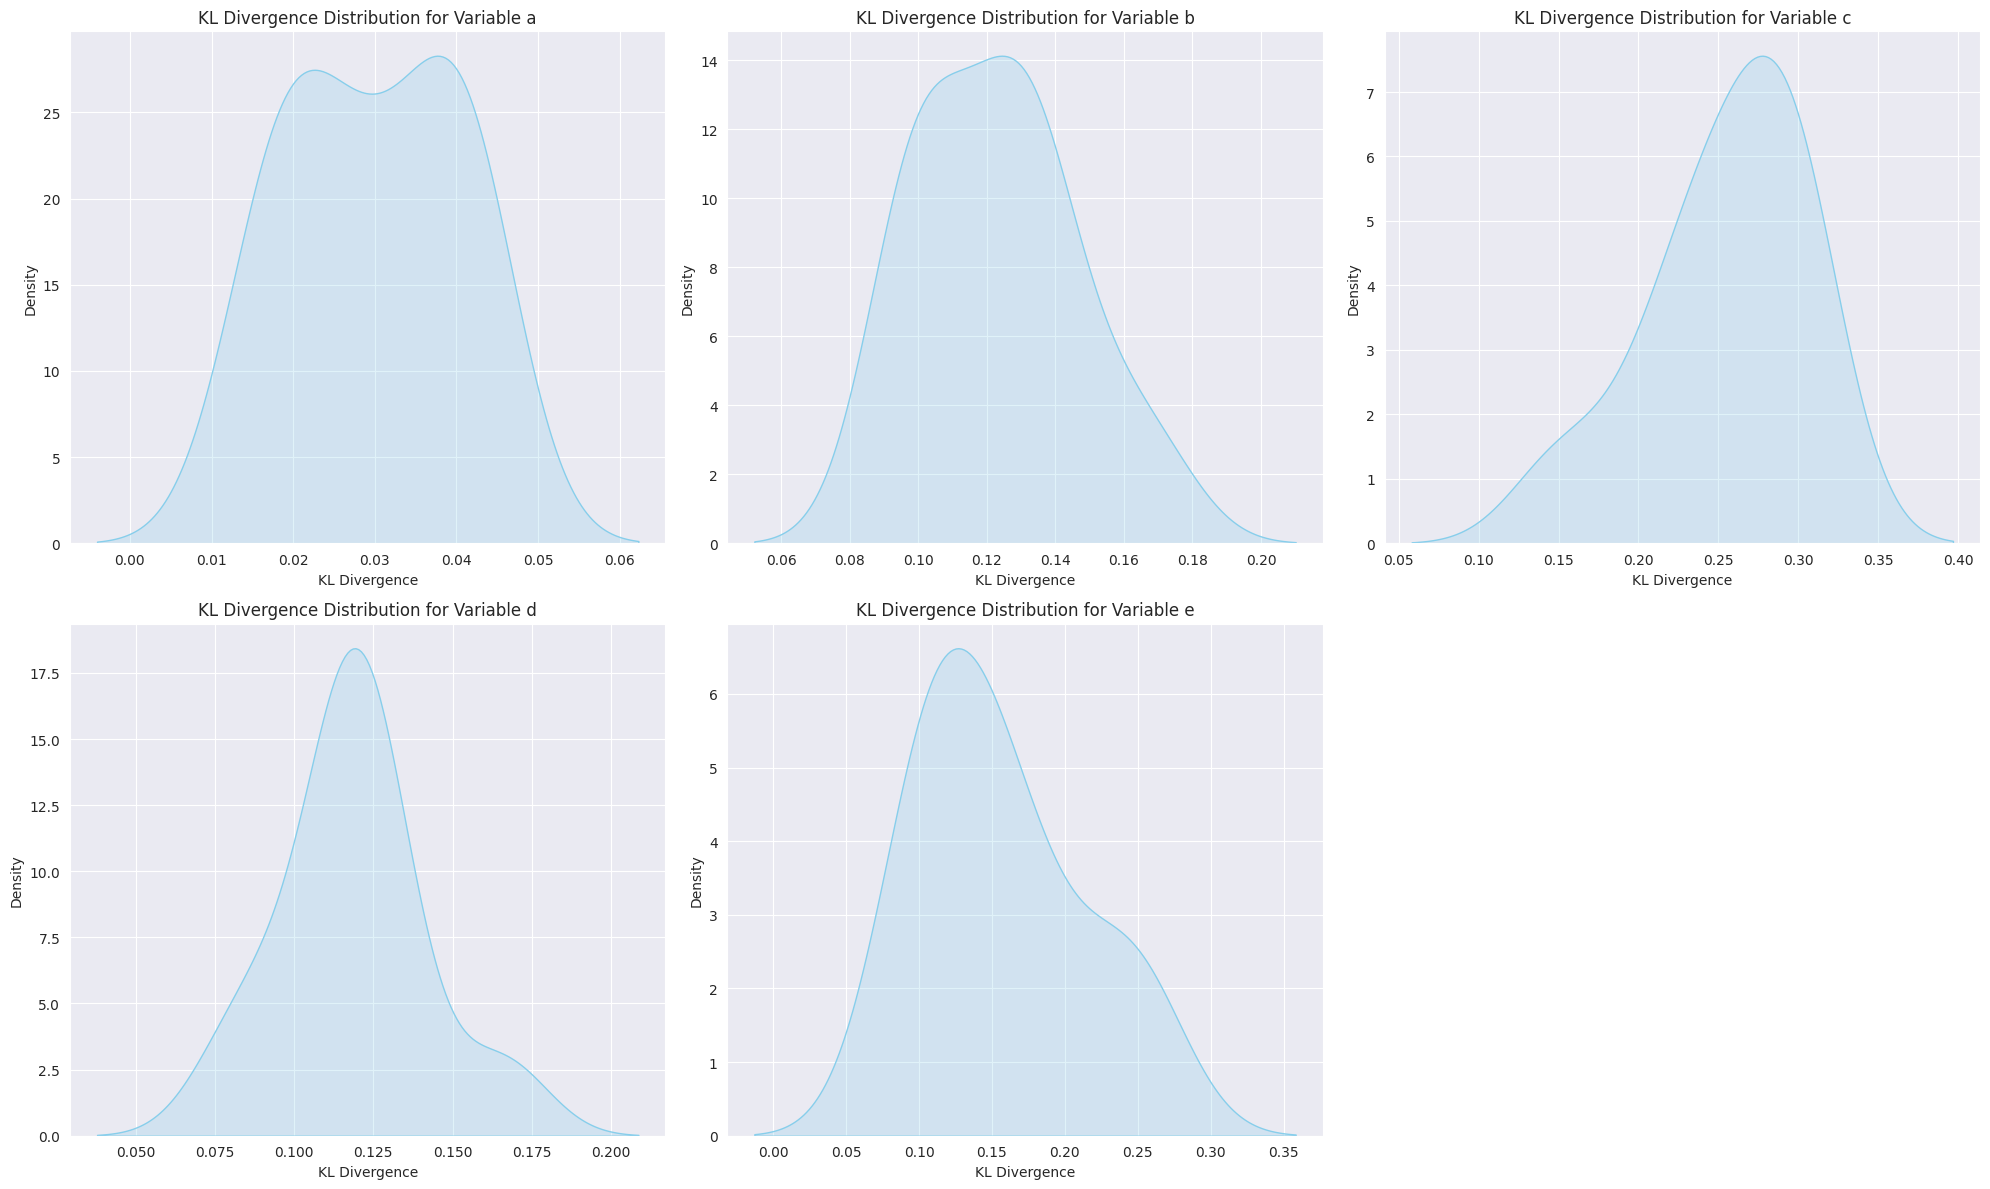

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for plotting
variables = list(kl_divs[0].keys())  # Assuming kldivs is a list of dictionaries

# Create subplots for each variable
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i, var in enumerate(variables):
    # Extract KL divergence values for the current variable
    kl_values = [kldiv[var] for kldiv in kl_divs]
    
    # Create a KDE plot for the current variable
    sns.kdeplot(kl_values, ax=axes[i], shade=True, color='skyblue')
    
    # Customize the subplot
    axes[i].set_title(f'KL Divergence Distribution for Variable {var}')
    axes[i].set_xlabel('KL Divergence')
    axes[i].set_ylabel('Density')

# Remove the empty subplot
fig.delaxes(axes[5])

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [37]:
import numpy as np

# Calculate mean and standard deviation for each variable
for var in variables:
    kl_values = [kldiv[var] for kldiv in kl_divs]
    mean = np.mean(kl_values)
    std = np.std(kl_values)
    print(f"Variable {var}:")
    print(f"  Mean KL Divergence: {mean:.4f}")
    print(f"  Standard Deviation: {std:.4f}")
    print()


Variable a:
  Mean KL Divergence: 0.0299
  Standard Deviation: 0.0098

Variable b:
  Mean KL Divergence: 0.1228
  Standard Deviation: 0.0217

Variable c:
  Mean KL Divergence: 0.2544
  Standard Deviation: 0.0466

Variable d:
  Mean KL Divergence: 0.1186
  Standard Deviation: 0.0215

Variable e:
  Mean KL Divergence: 0.1555
  Standard Deviation: 0.0530



attention ! on a de bons résultats mais pas exceptionnels non plus, lié au fait que la distribution est quasi gaussienne en vrai .. (cf le 1er plot tout en haut du notebook pour c et e )

voir le deuxieme notebook pour la méthode d'emilie

attention, ici on regarde des données déjà interventionnistes

Garbage

In [ ]:
import numpy as np


def generate_causal_data(n_schools, n_students):
    data = {}

    # Generate a
    for i in range(n_schools):
        data[f'a{i}'] = np.random.normal(0, 1)

    # Generate b based on a
    for i in range(n_schools):
        for j in range(n_students):
            data[f'_b{i}_{j}'] = (data[f'a{i}'] + 1) ** 2 + np.random.normal(0, 1)

    # Generate c based on a and b
    for i in range(n_schools):
        b_mean = np.mean([data[f'_b{i}_{j}'] for j in range(n_students)])
        data[f'c{i}'] = data[f'a{i}'] + (b_mean + 1) ** 2 + np.random.normal(0, 1)

    # Generate d based on b and c
    for i in range(n_schools):
        for j in range(n_students):
            data[f'_d{i}_{j}'] = (data[f'_b{i}_{j}'] + 1) ** 2 + data[f'c{i}'] + np.random.normal(0, 0.5)

    # Generate e based on c and d
    for i in range(n_schools):
        d_mean = np.mean([data[f'_d{i}_{j}'] for j in range(n_students)])
        data[f'e{i}'] = data[f'c{i}'] + (d_mean + 1) ** 2 + np.random.normal(0, 1)

    return data


# Usage
n_schools = 10
n_students = 50
graph = [('a', '_b'), ('a', 'c'), ('_b', 'c'), ('c', '_d'), ('_b', '_d'), ('_d', 'e'), ('c', 'e')]
data = generate_causal_data(n_schools, n_students)
n_schools = 50
n_students = 50

unit_vars = ['a', 'c', 'e']
subunit_vars = ['b', 'd']
sizes = [n_students] * n_schools

# Example usage
graph = [('a', '_b'), ('a', 'c'), ('_b', 'c'), ('c', '_d'), ('_b', '_d'), ('_d', 'e'), ('c', 'e')]
data = {
    **{f'a{i}': i + 1 for i in range(n_schools)},
    **{f'c{i}': i + 5 for i in range(n_schools)},
    **{f'e{i}': i + 11 for i in range(n_schools)}
}

# Generate data for b and d
for i in range(n_schools):
    for j in range(n_students):
        data[f'_b{i}_{j}'] = 2 * i + j % 2 + 1  # This creates a slight variation between students
        data[f'_d{i}_{j}'] = 2 * i + j % 2 + 7  # This creates a slight variation between students



In [1]:
import networkx as nx
import numpy as np
from scipy.stats import norm, gaussian_kde
from scipy.integrate import quad
import pymc as pm


In [2]:
def preprocess_data(self):
        data = {}
        for var in self.unit_vars:
            for i in range(len(self.sizes)):
                data[var+str(i)] = self.data[var+str(i)]
        for var in self.subunit_vars:
            for i in range(len(self.sizes)):
                s = 0
                for j in range(self.sizes[i]):
                    s += self.data['_'+var+str(i)+'_'+str(j)]
                data[var+str(i)] = s / self.sizes[i]
        return data

In [3]:

class HierarchicalBayesSampler:
    def __init__(self, graph, data, unit_vars, subunit_vars, sizes):
        self.graph = nx.DiGraph(graph)
        self.data = data
        self.unit_vars = unit_vars
        self.subunit_vars = subunit_vars
        self.sizes = sizes
        self.processed_data = self.preprocess_data()
        
    def preprocess_data(self):
        data = {}
        for var in self.unit_vars:
            for i in range(len(self.sizes)):
                data[var+str(i)] = self.data[var+str(i)]
        for var in self.subunit_vars:
            for i in range(len(self.sizes)):
                s = 0
                for j in range(self.sizes[i]):
                    s += self.data['_'+var+str(i)+'_'+str(j)]
                data[var+str(i)] = s / self.sizes[i]
        return data

    def generate(self):  # num_samples est maintenant 2
        num_samples = self.sizes[0]
        with pm.Model() as model:
            # Hyperpriors
            mu = {var: pm.Normal(f'mu_{var}', mu=0, sigma=1) for var in self.unit_vars + self.subunit_vars}
            sigma = {var: pm.HalfNormal(f'sigma_{var}', sigma=1) for var in self.unit_vars + self.subunit_vars}

            # Priors pour les variables de niveau supérieur
            variables = {}
            for var in self.unit_vars:
                variables[var] = pm.Normal(var, mu=mu[var], sigma=sigma[var], shape=len(self.sizes))

            # Priors pour les variables de niveau inférieur (sous-unités)
            subunit_variables = {}
            for var in self.subunit_vars:
                for i in range(len(self.sizes)):
                    subunit_variables[f'{var}{i}'] = pm.Normal(f'{var}{i}', mu=mu[var], sigma=sigma[var], shape=self.sizes[i])

            # Likelihood pour les variables de niveau supérieur
            for var in self.unit_vars:
                pm.Normal(f'obs_{var}', mu=variables[var], sigma=1, 
                        observed=np.array([self.processed_data[f'{var}{i}'] for i in range(len(self.sizes))]))

            # Likelihood pour les variables de niveau inférieur (sous-unités)
            for var in self.subunit_vars:
                for i in range(len(self.sizes)):
                    pm.Normal(f'obs_{var}{i}', 
                            mu=subunit_variables[f'{var}{i}'], 
                            sigma=1, 
                            observed=np.array([self.data[f'_{var}{i}_{j}'] for j in range(self.sizes[i])]))

            # Sampling
            trace = pm.sample(num_samples, return_inferencedata=False)

        # Extraction des échantillons
        generated_data = {}
        for var in self.unit_vars:
            generated_data[var] = trace[var][0]  # Prend le premier (et seul) échantillon

        # Extraction et génération des sous-unités
        for var in self.subunit_vars:
            for i in range(len(self.sizes)):
                generated_data[f'{var}{i}'] = trace[f'{var}{i}'][0]  # Prend le premier (et seul) échantillon

        return generated_data
    
    def generate_cond(self):
        num_samples = self.sizes[0]
        with pm.Model() as model:
            # Hyperpriors pour les autres variables
            mu = {var: pm.Normal(f'mu_{var}', mu=0, sigma=1) for var in self.unit_vars + ['d']}
            sigma = {var: pm.HalfNormal(f'sigma_{var}', sigma=1) for var in self.unit_vars + ['d']}

            # Priors pour les variables de niveau supérieur
            variables = {}
            for var in self.unit_vars:
                variables[var] = pm.Normal(var, mu=mu[var], sigma=sigma[var], shape=len(self.sizes))

            # b est défini comme une variable observée suivant une loi normale standard
            b = pm.Normal('b', mu=0, sigma=1, shape=(len(self.sizes), max(self.sizes)), observed=np.random.normal(0, 1, (len(self.sizes), max(self.sizes))))

            # Priors pour les autres variables de niveau inférieur (d)
            subunit_variables = {}
            for i in range(len(self.sizes)):
                subunit_variables[f'd{i}'] = pm.Normal(f'd{i}', mu=mu['d'], sigma=sigma['d'], shape=self.sizes[i])

            # Likelihood pour les variables de niveau supérieur
            for var in self.unit_vars:
                pm.Normal(f'obs_{var}', mu=variables[var], sigma=1, 
                        observed=np.array([self.processed_data[f'{var}{i}'] for i in range(len(self.sizes))]))

            # Likelihood pour d
            for i in range(len(self.sizes)):
                pm.Normal(f'obs_d{i}', 
                        mu=subunit_variables[f'd{i}'], 
                        sigma=1, 
                        observed=np.array([self.data[f'_d{i}_{j}'] for j in range(self.sizes[i])]))

            # Sampling
            trace = pm.sample(num_samples, return_inferencedata=False)

        # Extraction des échantillons
        generated_data = {}
        for var in self.unit_vars:
            generated_data[var] = trace[var][0]

        # Génération de b (toujours à partir d'une loi normale standard)
        for i in range(len(self.sizes)):
            generated_data[f'b{i}'] = np.random.normal(0, 1, size=self.sizes[i])

        # Extraction de d
        for i in range(len(self.sizes)):
            generated_data[f'd{i}'] = trace[f'd{i}'][0]

        return generated_data




In [7]:
import json

def load_data_from_json(file_path):
    """
    Load data from a JSON file and return it as a dictionary.
    
    :param file_path: Path to the JSON file
    :return: Dictionary containing the loaded data
    """
    try:
        with open(file_path, 'r') as file:
            data = json.load(file)
        print(f"Data successfully loaded from {file_path}")
        return data
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except json.JSONDecodeError:
        print(f"Error: Invalid JSON format in {file_path}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {str(e)}")
        return None



In [8]:
data = load_data_from_json('data/sampled_data.json')

Data successfully loaded from data/sampled_data.json


In [9]:

graph = [('a', '_b'), ('a', 'c'), ('_b', 'c'), ('c', '_d'), ('_b', '_d'), ('_d', 'e'), ('c', 'e')]
n_schools = 50
n_students = 50

unit_vars = ['a', 'c', 'e']
subunit_vars = ['b', 'd']
sizes = [n_students] * n_schools

sampling

In [10]:

sampler = HierarchicalBayesSampler(graph, data, unit_vars, subunit_vars, sizes)


In [ ]:
generated_data = sampler.generate()

Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu_a, mu_c, mu_e, mu_b, mu_d, sigma_a, sigma_c, sigma_e, sigma_b, sigma_d, a, c, e, b0, b1, b2, b3, b4, b5, b6, b7, b8, b9, b10, b11, b12, b13, b14, b15, b16, b17, b18, b19, b20, b21, b22, b23, b24, b25, b26, b27, b28, b29, b30, b31, b32, b33, b34, b35, b36, b37, b38, b39, b40, b41, b42, b43, b44, b45, b46, b47, b48, b49, d0, d1, d2, d3, d4, d5, d6, d7, d8, d9, d10, d11, d12, d13, d14, d15, d16, d17, d18, d19, d20, d21, d22, d23, d24, d25, d26, d27, d28, d29, d30, d31, d32, d33, d34, d35, d36, d37, d38, d39, d40, d41, d42, d43, d44, d45, d46, d47, d48, d49]


Output()

In [97]:
print( generated_data)


{'a': array([ 1.63065515,  1.7902874 ,  3.64379826,  4.20047022,  5.45190432,
        6.2507369 ,  7.24115763,  8.26437485, 10.2955575 , 10.88087505,
        9.52584466, 12.00288655, 14.51193756, 13.28003449, 14.05469803,
       13.87207749, 16.33657466, 19.49652471, 19.69615   , 19.35336748,
       19.77505565, 22.01298776, 23.0668964 , 24.23471286, 26.58541814,
       27.80412966, 27.22020489, 27.80914964, 29.2355082 , 29.61532339,
       29.50518518, 32.38111287, 32.66135276, 32.95779157, 35.86792962,
       36.30651974, 37.76048832, 39.49839915, 38.49655652, 39.32357128,
       38.85188431, 41.19294883, 41.18251028, 43.25409831, 45.93033013,
       45.32301705, 45.29567944, 47.19897617, 48.98364624, 50.2227248 ]), 'c': array([ 5.18359223,  6.57355743,  7.04102518,  6.76520866,  8.96573395,
        9.88228739, 11.62027158, 11.13115107, 13.83440859, 13.78365585,
       13.96381998, 16.57984348, 16.9390979 , 16.86406085, 20.5648649 ,
       19.55889189, 20.82874816, 20.15223973, 21.07

In [ ]:

generated_data_cond = sampler.generate_cond()

Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu_a, mu_c, mu_e, mu_d, sigma_a, sigma_c, sigma_e, sigma_d, a, c, e, d0, d1, d2, d3, d4, d5, d6, d7, d8, d9, d10, d11, d12, d13, d14, d15, d16, d17, d18, d19, d20, d21, d22, d23, d24, d25, d26, d27, d28, d29, d30, d31, d32, d33, d34, d35, d36, d37, d38, d39, d40, d41, d42, d43, d44, d45, d46, d47, d48, d49]


Output()

Output()

In [ ]:
print(generated_data_cond)

In [ ]:
from scipy.stats import entropy

def kl_divergence(p, q):
    """
    Calcule la divergence KL entre deux distributions empiriques représentées par des tableaux.
    
    :param p: Premier tableau de données
    :param q: Second tableau de données
    :return: Valeur de la divergence KL
    """
    # Assurez-vous que les tableaux ont la même taille
    min_len = min(len(p), len(q))
    p = p[:min_len]
    q = q[:min_len]
    
    # Calculez les histogrammes des deux distributions
    bins = np.linspace(min(np.min(p), np.min(q)), max(np.max(p), np.max(q)), 1000)
    p_hist, _ = np.histogram(p, bins=bins, density=True)
    q_hist, _ = np.histogram(q, bins=bins, density=True)
    
    # Ajoutez un petit epsilon pour éviter la division par zéro
    epsilon = 1e-10
    p_hist += epsilon
    q_hist += epsilon
    
    # Normalisez les histogrammes
    p_hist /= np.sum(p_hist)
    q_hist /= np.sum(q_hist)
    
    # Calculez la divergence KL
    return entropy(p_hist, q_hist)


In [ ]:
# Compute KL divergence for 'e' variable
e_generated = generated_data['e']
e_original = np.array([sampler.processed_data[f'e{i}'] for i in range(len(sizes))])

e_generated_cond = generated_data_cond['e']




In [ ]:
kl_div = kl_divergence(e_original, e_generated)
print(f"KL divergence between original 'e' and generated 'e': {kl_div}")
kl_div_cond = kl_divergence(e_original, e_generated_cond)
print(f"KL divergence between original 'e' and generated 'e' with conditionning: {kl_div_cond}")


In [4]:
import numpy as np

In [5]:
import pymc as pm

In [21]:
import numpy as np

def generate_causal_data(n_schools, n_students):
    data = {}
    
    # Generate a
    for i in range(n_schools):
        data[f'a{i}'] =np.random.normal(0, 1)
    
    # Generate b based on a
    for i in range(n_schools):
        for j in range(n_students):
            data[f'_b{i}_{j}'] = (data[f'a{i}']+1)**2 + np.random.normal(0, 1)
    
    # Generate c based on a and b
    for i in range(n_schools):
        b_mean = np.mean([data[f'_b{i}_{j}'] for j in range(n_students)])
        data[f'c{i}'] = data[f'a{i}'] +(b_mean+1)**2 + np.random.normal(0, 1)
    
    # Generate d based on b and c
    for i in range(n_schools):
        for j in range(n_students):
            data[f'_d{i}_{j}'] = (data[f'_b{i}_{j}']+1)**2 +data[f'c{i}'] + np.random.normal(0, 0.5)
    
    # Generate e based on c and d
    for i in range(n_schools):
        d_mean = np.mean([data[f'_d{i}_{j}'] for j in range(n_students)])
        data[f'e{i}'] = data[f'c{i}'] + (d_mean+1)**2 + np.random.normal(0, 1)
    
    return data

# Usage
n_schools = 50
n_students = 50
graph = [('a', '_b'), ('a', 'c'), ('_b', 'c'), ('c', '_d'), ('_b', '_d'), ('_d', 'e'), ('c', 'e')]
data = generate_causal_data(n_schools, n_students)